# Behavioral performance

We want a few graphs to summarize the performance of mice on the autopi task.

We need to do statistical analysis with one score per mouse.

In [11]:
%load_ext autoreload
%autoreload 2

import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", message="Passing `palette` without assigning `hue` is deprecated")

%run ../../setup_project.py
%run ../../generic_plot_functions.py

import os.path
import shutil
from scipy.stats import mannwhitneyu, pearsonr, wilcoxon, binned_statistic,friedmanchisquare,linregress
import matplotlib.image as mpimg
from statannotations.Annotator import Annotator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
PROJECT_DATA_PATH

'E:\\GitHub\\Peng_et.al_2025_noInt\\Peng'

In [13]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: E:\GitHub\Peng_et.al_2025_noInt\Peng
dlcModelPath: 
Reading E:\GitHub\Peng_et.al_2025_noInt\Peng/sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


## Get a DataFrame with behavioral variables for all trials in the dataset. 

In [14]:
ses = myProject.sessionList[145]

In [15]:
def getBehavioralDf(ses):
    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        sesL = pickle.load(handle)
    return sesL.getTrialVariablesDataFrame()

In [16]:
df = getBehavioralDf(ses)

## Analysis on merge data frame

In [17]:
fn = dataPath+"/results/trialsTable"
df = pd.read_csv(fn)

We get some variables that can be used to start the Results section.

In [18]:
print("Number of valid trials: {}".format(np.sum(df.valid==True)))
print("Proportion of invalid trials: {:.3f}".format(np.sum(df.valid==False)/df.shape[0]))
print("Removing invalid trials")
df = df[df.valid]
print("Number of light trials: {}".format(np.sum(df.light=="light")))
print("Number of dark trials: {}".format(np.sum(df.light=="dark")))
print("Number of mice: {}".format(len(df.subject.unique())))
print("Number of recording session: {}".format(len(df.sessionName.unique())))

Number of valid trials: 19751
Proportion of invalid trials: 0.000
Removing invalid trials
Number of light trials: 10476
Number of dark trials: 9275
Number of mice: 17
Number of recording session: 180


We need to know how many sessions per animal.

In [19]:
def numberOfSessions(df):
    """
    Get the number of sessions
    """
    return len(df.sessionName.unique())

In [20]:
res = df.groupby([df['subject']]).apply(numberOfSessions).reset_index()
res.columns = ["subject","sessions"]
res

,subject,sessions
0,jp1084,11
1,jp1684,4
2,jp1685,7
3,jp1686,8
4,jp1687,4
5,jp3120,10
6,jp3129,9
7,jp3130,3
8,jp3269,8
9,jp451,14


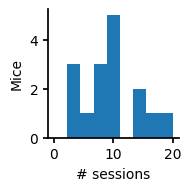

In [21]:
rowSize,colSize= figurePanelDefaultSize()
setFigureDefaultParameters()
fig = plt.figure(figsize=(1*colSize, 1*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1) # create a GridSpec object to a figure
ax = fig.add_subplot(spec[0]) # add an axes to the figure
ax.hist(res.sessions,bins=np.linspace(0,20,10))
ax.set_ylabel("Mice")
ax.set_xlabel("# sessions")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)  

In [22]:
print("Minimum number of session for a mouse:",res["sessions"].min())
print("Maximum number of session for a mouse:",res["sessions"].max())
print("Median number of session for a mouse:",res["sessions"].median())

Minimum number of session for a mouse: 3
Maximum number of session for a mouse: 25
Median number of session for a mouse: 10.0


In [23]:
res = df.groupby([df['subject']])
res

We need to know how many trials per sessions.

In [24]:
res = df.groupby([df['sessionName']])["trialNo"].count()
print("Minimum number of trials per session:", res.min())
print("Maximum number of trials per session:", res.max())
print("Median number of trials per session:", res.median())

Minimum number of trials per session: 38
Maximum number of trials per session: 172
Median number of trials per session: 111.5


We can get the search path length and error at periphery for each mice (median) for light and dark trials. Then we show the results in a boxplot. The statistical unit will be each mouse.

In [25]:
GLOBALFONTSIZE = 9

def calculatePvalue(Pvalue):
    """
    Calculate the symbol to plot based on the given p-value.

    Parameters:
        Pvalue (float): The p-value to calculate the symbol for.

    Returns:
        str: The symbol to plot based on the p-value.
    """

    
    if Pvalue < 0.0001:
        symbolToPlot = '****'
    elif Pvalue < 0.001:
        symbolToPlot = '***'
    elif Pvalue < 0.01:
        symbolToPlot = '**'
    elif Pvalue < 0.05:
        symbolToPlot = '*'
    else:
        symbolToPlot = 'ns'

    return symbolToPlot



    
def draw_stats_bar(ax,A,B,height=0.95,pValue=1):
    """
    Draws a statistics bar on the given axes.

    Parameters:
        ax (Axes): The axes on which to draw the statistics bar.
        A (float): The starting x-coordinate of the bar.
        B (float): The ending x-coordinate of the bar.
        height (float, optional): The height of the bar. Defaults to 0.95.
        pValue (int, optional): The p-value to calculate. Defaults to 1.

    Returns:
        None
    """
    line_x = [A, B]
    line_y = [height,height]

    #Add the horizontal line
    ax.plot(line_x,line_y, color='black', linewidth=1.5,transform=ax.transAxes)

    #Add the two wiskers
    wiskerLeftX = [A, A]
    wiskerLeftY = [height-0.025,height]

    ax.plot(wiskerLeftX,wiskerLeftY, color='black', linewidth=1.5,transform=ax.transAxes)

    wiskerRightX = [B, B]
    wiskerRightY = [height-0.025,height]

    ax.plot(wiskerRightX,wiskerRightY, color='black', linewidth=1.5,transform=ax.transAxes)

    #Add P-Value
    ax.text((A+B)/2, height+0.05, f'{calculatePvalue(pValue)}', fontsize=GLOBALFONTSIZE+1, transform=ax.transAxes,ha='center', va='center')


In [26]:
def plotSearchLength(ax,df):
    dfg = df["searchLength"].groupby([df['subject'],df["light"]])
    dfg = dfg.median().reset_index()
    dfg.light[dfg["light"]=="light"] = "Light"
    dfg.light[dfg["light"]=="dark"] = "Dark"
    
    myColors = darkLightColors()


    # statistics
    u,p =  wilcoxon(dfg.searchLength[dfg["light"]=="Light"],
                        dfg.searchLength[dfg["light"]=="Dark"])

    draw_stats_bar(ax,0.25,0.75,height=0.75,pValue=p)
    print(u,p)
    n = len(dfg.searchLength[dfg["light"]=="Dark"])
    ax.text(0.05, 0.9, f"N = {n}",fontsize=9,transform=ax.transAxes)


    b = sns.stripplot(data=dfg, x="light",y="searchLength",order = ["Dark","Light"],palette=darkLightColors(lighter=False),alpha=0.5,
                  size=5,edgecolor='#373737', linewidth=1, color='black',ax=ax)
    
    ymax=200
    ax.set_ylim(0,ymax)
    ax.set_yticks([0,50,100,150,200])
    ax.set_ylabel("Search path\n length (cm)")
    ax.set_xlabel("")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
    
    

    

def plotHomingErrorAtPeripheryAbsolute(ax,df):
    
    df["homingErrorAtPeripheryAbsolute"] = df.homingErrorAtPeriphery.abs()
    
    dfg = df["homingErrorAtPeripheryAbsolute"].groupby([df['subject'],df["light"]])
    dfg = dfg.median().reset_index()
    dfg.light[dfg["light"]=="light"] = "Light"
    dfg.light[dfg["light"]=="dark"] = "Dark"
    
    myColors = darkLightColors()

    # statistics
    u,p =  wilcoxon(dfg["homingErrorAtPeripheryAbsolute"][dfg["light"]=="Light"],
                        dfg["homingErrorAtPeripheryAbsolute"][dfg["light"]=="Dark"])
    print(u,p)
    n = len(dfg["homingErrorAtPeripheryAbsolute"][dfg["light"]=="Dark"])

    
    ax.plot([-0.5,1.5],[np.pi/2,np.pi/2],"--",color="gray")
    ax.text(0.5,np.pi/2+0.1,"Chance level",horizontalalignment='center',fontsize=9)

    draw_stats_bar(ax,0.25,0.75,height=0.65,pValue=p)


    sns.stripplot(data=dfg, x="light",y="homingErrorAtPeripheryAbsolute",order = ["Dark","Light"],hue="light",palette=darkLightColors(lighter=False), alpha=0.5,
                  size=5,edgecolor='#373737', linewidth=1, color='black')
    
    
    ymax=np.pi/2 + .2
    ax.set_ylim(0,ymax)
    ax.set_xlim(-0.5,1.5)
    ax.set_yticks([0,np.pi/4,np.pi/2])
    ax.set_yticklabels(["0",r'$\pi/4$', "$\pi/2$"])
    
    ax.set_ylabel("Error at peri.\n(rad)")
    ax.set_xlabel("")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    plt.legend([],[], frameon=False) 

    
    

0.0 1.52587890625e-05
0.0 1.52587890625e-05


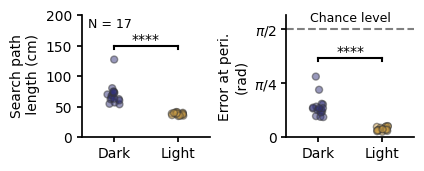

In [27]:
rowSize,colSize= figurePanelDefaultSize()
nPlots=3

fig = plt.figure(figsize=(nPlots*colSize, 1*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=nPlots, nrows=2,height_ratios=[0.15,0.9]) # create a GridSpec object to a figure
ax = fig.add_subplot(spec[1,0]) # add an axes to the figure
plotSearchLength(ax,df)

ax = fig.add_subplot(spec[1,1]) # add an axes to the figure
plotHomingErrorAtPeripheryAbsolute(ax,df)

plt.show()

We need evidence that the homing error is correlated with search path length. We can calculate the correlation between search path length and homing error for each mouse. See if we consistently get positive correlation coefficients.

In [28]:
def correlationSearchLengthHomingAccuracy(df, lightCondition = "dark", returnR=True, shuffle=False):
    """
    Get the pearson correlation coefficient between searchLength and homingErrorAtPeripheryAbsolute
    """
    dfD = df[df["light"]==lightCondition]
    dfD = dfD[["searchLength","homingErrorAtPeripheryAbsolute"]]
    # remove excessively long trials (extreme values)
    dfD["searchLength"][dfD["searchLength"]>500] = np.nan
    # remove np.nan
    dfD = dfD.dropna()


    if shuffle:
        shift=10
        r,p = pearsonr(dfD["homingErrorAtPeripheryAbsolute"],np.roll(dfD["searchLength"].to_numpy(),shift=shift))
    
    else:
        r,p = pearsonr(dfD["homingErrorAtPeripheryAbsolute"],dfD["searchLength"])
    if returnR:
        return r
    else:
        return p

def plotCorrelationSearchLengthHomingAccuracyPerMouse(ax,df):
    """
    Plot a distribution of Pearson correlation coefficients 
    """
    resDark = df.groupby(df['subject']).apply(correlationSearchLengthHomingAccuracy,lightCondition="dark",shuffle=False).reset_index()
    resDark.columns = ["subject","r"]
    
    resLight = df.groupby(df['subject']).apply(correlationSearchLengthHomingAccuracy,lightCondition="light",shuffle=False).reset_index()
    resLight.columns = ["subject","r"]
    
    
    sns.histplot(data=resDark, x="r",bins=np.linspace(-0.2,0.6,10),color=darkLightColors()[0],alpha=0.5,label="Dark")
    sns.histplot(data=resLight, x="r",bins=np.linspace(-0.2,0.6,10),color=darkLightColors()[1],alpha=0.5,label="Light")
    
    ax.legend(loc=0,fontsize=8, bbox_to_anchor=(0.06, 0.4, 0.5, 0.5))
    
    
    y,x = np.histogram(resDark.r,bins = np.linspace(-0.2,0.6,10))
    ax.set_xlim(-0.6,0.6)
    ymax=np.max(y)+3
    
    ax.set_ylim(0,ymax)
    ax.set_xlabel("Search-Homing r")
    ax.set_ylabel("Mice")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
    
    # statistics
    stat, p = wilcoxon(resDark.r,resLight.r)
    print("Wilcoxon on r values:",stat,p)
    n = len(resDark.r)
    ax.text(-0.27, ymax*0.9, formatPValue(p),fontsize=9)
   
    return

Wilcoxon on r values: 7.0 0.0002899169921875


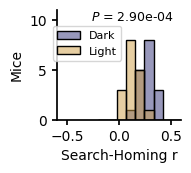

In [29]:
nPlots=1
fig = plt.figure(figsize=(nPlots*colSize, 1*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=nPlots, nrows=2,height_ratios=[0.15,0.9]) # create a GridSpec object to a figure
ax = fig.add_subplot(spec[1,0]) # add an axes to the figure
plotCorrelationSearchLengthHomingAccuracyPerMouse(ax,df)
plt.show()

We can get the p-values for these correlations. Their meaning is not clear because the raw data is not normally distributed.

In [30]:
print(df.groupby(df['subject']).apply(correlationSearchLengthHomingAccuracy,returnR=True).reset_index())
print(df.groupby(df['subject']).apply(correlationSearchLengthHomingAccuracy,returnR=False).reset_index())

   subject         0
0   jp1084  0.195079
1   jp1684  0.092393
2   jp1685  0.159930
3   jp1686  0.414588
4   jp1687  0.368386
5   jp3120  0.243540
6   jp3129  0.205447
7   jp3130  0.285232
8   jp3269  0.266693
9    jp451  0.269910
10   jp452  0.280652
11   jp486  0.289663
12   jp487  0.190059
13   jp497  0.320573
14   jp499  0.273927
15  mn8578  0.389315
16  mn8599  0.312325
   subject             0
0   jp1084  3.351285e-05
1   jp1684  1.876380e-01
2   jp1685  2.440644e-02
3   jp1686  1.838356e-18
4   jp1687  4.383225e-08
5   jp3120  2.037414e-08
6   jp3129  7.616567e-06
7   jp3130  3.363290e-04
8   jp3269  1.858936e-09
9    jp451  1.527465e-11
10   jp452  3.431753e-14
11   jp486  6.685438e-31
12   jp487  1.264580e-03
13   jp497  1.020346e-12
14   jp499  2.470949e-10
15  mn8578  4.092758e-23
16  mn8599  4.225228e-25


We could show the homing error for short and long search path. Short and long are established on the search length for each mouse.

In [31]:
def homingErrorFunctionSearchLength(df,lightCondition="dark"):
    
    dfD = df[df["light"]==lightCondition]
    dfD = dfD[["searchLength","homingErrorAtPeripheryAbsolute"]]
    # remove excessively long trials (extreme values)
    dfD["searchLength"][dfD["searchLength"]>500] = np.nan
    # remove np.nan
    dfD = dfD.dropna()

    # get median for different search length
    med, b, bn =  binned_statistic(dfD["searchLength"], dfD["homingErrorAtPeripheryAbsolute"], statistic='median', bins=np.linspace(0,250,6), range=None)

    return pd.Series(med, index= b[:-1]+ (b[1]-b[0]))

def plotHomingErrorFunctionSearchLength(ax,df):
    res = df.groupby(df['subject']).apply(homingErrorFunctionSearchLength,lightCondition="dark").reset_index()
    res = pd.melt(res, id_vars="subject",var_name='search', value_name='homing')
    res.search = res.search.astype(float)
  
    linres = linregress(x = res.search, y = res.homing)
    X = np.linspace(25,275,100)
    Y = X*linres[0]+linres[1]
   
    sns.stripplot(data=res,x="search",y="homing",native_scale=True,  alpha=0.7, color =[darkLightColors(lighter=True)[0]],
                  size=5,edgecolor='#373737', linewidth=1)
    ax.plot(X,Y,color="grey")
    ax.set_xlabel("Search length (cm)")
    ax.set_ylabel("Error at peri.\n(rad)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    ax.set_xticks([50,150,250])
    ymax=np.pi/2+0.3
    ax.set_xlim(0,275)
    ax.set_ylim(0,ymax)
        
    # statistics
    q,p = friedmanchisquare(res["homing"][res["search"]==50.0],
                                res["homing"][res["search"]==100.0],
                                res["homing"][res["search"]==150.0],
                                res["homing"][res["search"]==200.0],
                                res["homing"][res["search"]==250.0])
    print("Friedman chi-square:",q,p)
    n = len(res["homing"][res["search"]==50.0])
   
    
    ax.set_yticks([0,np.pi/4,np.pi/2])
    ax.set_yticklabels(["0",r'$\pi/4$', "$\pi/2$"])
    
    ax.text(0.05, 0.9, formatPValue(p),fontsize=9,transform=ax.transAxes)
    

In [32]:
if:

SyntaxError: invalid syntax (879943805.py, line 1)

# Revised figure

Figure width: 7.32
Figure height: 6.8
0.0 1.52587890625e-05
0.0 1.52587890625e-05
Friedman chi-square: 45.60000000000002 2.9830653644842347e-09
Wilcoxon on r values: 7.0 0.0002899169921875


FileNotFoundError: [Errno 2] No such file or directory: '../../Output/Figure1.pdf'

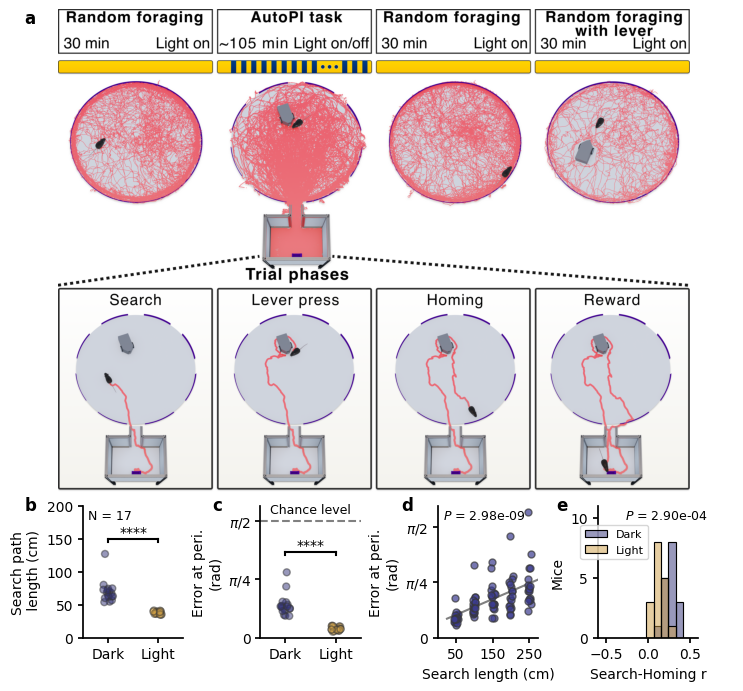

In [33]:
rowSize,colSize= 1.7,1.83 #figurePanelDefaultSize()

ncols=4
nrows=4

print("Figure width: {}".format(ncols*colSize))
print("Figure height: {}".format(nrows*rowSize))


fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure


specLetters = fig.add_gridspec(ncols=1, nrows=1) # create a GridSpec object to a figure



gs = gridspec.GridSpec(nrows, ncols, figure=fig,height_ratios=[0.94,0.93,0.92,1.09],width_ratios=[0.02,1,1,1])
gStats = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=gs[3:, :],width_ratios=[0.01,1,1,1,1,0.25])

fn = os.path.join(PROJECT_DATA_PATH,'data','protocol_m_rerender.png')

img = mpimg.imread(fn)
ax = fig.add_subplot(gs[:3,1:]) # add an axes to the figure
ax.imshow(img)
ax.set_aspect('equal', adjustable='box')
ax.axis('off')




ax = fig.add_subplot(gStats[0,1]) # add an axes to the figure
plotSearchLength(ax,df)

ax = fig.add_subplot(gStats[0,2]) # add an axes to the figure
plotHomingErrorAtPeripheryAbsolute(ax,df)

ax = fig.add_subplot(gStats[0,3]) # add an axes to the figure
plotHomingErrorFunctionSearchLength(ax,df)

ax = fig.add_subplot(gStats[0,4]) # add an axes to the figure
plotCorrelationSearchLengthHomingAccuracyPerMouse(ax,df)

ax = fig.add_subplot(specLetters[0]) # add an axes to the figure

ax.text(0.02,1, 'a', style='normal',fontsize=12, weight="bold")
ax.text(0.02,0.26, 'b', style='normal',fontsize=12, weight="bold")
ax.text(0.28,0.26, 'c', style='normal',fontsize=12, weight="bold")
ax.text(0.54,0.26, 'd', style='normal',fontsize=12, weight="bold")
ax.text(0.755,0.26, 'e', style='normal',fontsize=12, weight="bold")

ax.axis("off")

plt.savefig('../../Output/Figure1.pdf', bbox_inches='tight', dpi=300)